In [1]:
import ntpath
import os
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt
import sklearn
import cv2

2023-06-09 09:42:16.548928: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
input_shape = (224, 224)
number_of_epochs = 20
'''
train_percentage = 0.7
validation_percentage = 0.2
test_percentage = 0.1
'''
weights_directory = "/Users/andreacivitarese/PycharmProjects/CVandDL/classification/weights"
results_directory = "/Users/andreacivitarese/PycharmProjects/CVandDL/classification/results"
path_dataset_men = "/Users/andreacivitarese/PycharmProjects/CVandDL/dataset_classificazione/men/"
path_dataset_women = "/Users/andreacivitarese/PycharmProjects/CVandDL/dataset_classificazione/women/"


In [3]:
# Codice per ottenere il path delle immagini da classificare
imgs_list_men = [os.path.join(path_dataset_men, img_name) for img_name in os.listdir(path_dataset_men)]
imgs_list_women = [os.path.join(path_dataset_women, img_name) for img_name in os.listdir(path_dataset_women)]
imgs_list = imgs_list_men + imgs_list_women

print("Numero totale immagini: " + str(len(imgs_list)))

imgs_array = []
for file_path in imgs_list:
    img = cv2.imread(file_path)
    img = cv2.resize(img, input_shape)
    #RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs_array.append(img)

Numero totale immagini: 1373


[[[226 221 218]
  [226 221 218]
  [226 221 218]
  ...
  [226 221 218]
  [226 221 218]
  [226 221 218]]

 [[226 221 218]
  [226 221 218]
  [226 221 218]
  ...
  [226 221 218]
  [226 221 218]
  [226 221 218]]

 [[226 221 218]
  [226 221 218]
  [226 221 218]
  ...
  [226 221 218]
  [226 221 218]
  [226 221 218]]

 ...

 [[230 227 223]
  [230 227 223]
  [230 227 223]
  ...
  [230 227 223]
  [230 227 223]
  [230 227 223]]

 [[230 227 223]
  [230 227 223]
  [230 227 223]
  ...
  [230 227 223]
  [230 227 223]
  [230 227 223]]

 [[230 227 223]
  [230 227 223]
  [230 227 223]
  ...
  [230 227 223]
  [230 227 223]
  [230 227 223]]]
/Users/andreacivitarese/PycharmProjects/CVandDL/dataset_classificazione/men/51_GUCCI_calf-leather.jpg


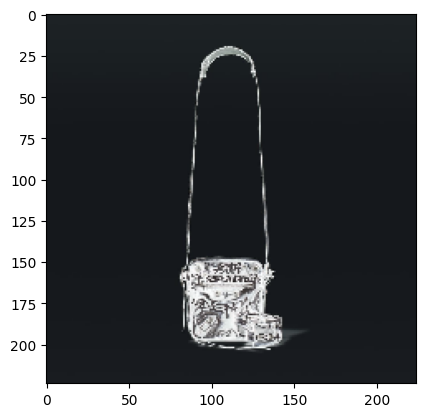

In [4]:
print(imgs_array[0])
print(imgs_list[0])

imgplot = plt.imshow(255-imgs_array[1], vmin=0, vmax=255)

In [5]:
# creazione delle etichette delle immagini
possible_materials = set()
for image_path in imgs_list:
    head, image_name = ntpath.split(image_path)
    index, brand, material = image_name.split('_')
    materials = material.split('+')
    for materiale in materials:
        possible_materials.add(materiale.split('.')[0])
list_possible_materials = list(possible_materials)

print("Numero possibili materiali: " + str(len(possible_materials)))
print(list_possible_materials)

labels = []

for image_path in imgs_list:
    head, image_name = ntpath.split(image_path)
    index, brand, material = image_name.split('_')
    materials = material.split('+')
    label = np.zeros(shape=len(possible_materials), dtype=float)
    for materiale in materials:
        materiale = materiale.split('.')[0]
        indice = list_possible_materials.index(materiale)
        label[indice] = 1
    labels.append(label)

print(str(len(labels)))

Numero possibili materiali: 22
['raffia', 'cow-leather', 'palm-leaf', 'mercerised-cotton', 'brass', 'velvet', 'Plexiglas®', 'calf-leather', 'polyurethane', 'leather', 'jute', 'organic-cotton', 'canvas', 'fabric', 'recycled-nylon', 'plastic', 'lamb-fur', 'lamb-leather', 'goat-leather', 'polyester', '100%-cotton', 'ethylene-vinyl-acetate']
1373


In [6]:
from sklearn.model_selection import train_test_split

images_array, labels_array = sklearn.utils.shuffle(imgs_array, labels, random_state=15)
Xtrain, X_test, Ytrain, Y_test = train_test_split(images_array,labels_array, test_size=0.10,  random_state=55)
X_train, X_valid, Y_train, Y_valid = train_test_split(Xtrain, Ytrain, test_size=0.2,  random_state=55)

X_train = np.asarray(X_train)
X_valid = np.asarray(X_valid)
X_test = np.asarray(X_test)
Y_train = np.asarray(Y_train)
Y_valid = np.asarray(Y_valid)
Y_test = np.asarray(Y_test)

In [7]:
mobilenet_v3 = tf.keras.applications.MobileNetV3Small(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

model = tf.keras.Sequential()
model.add(mobilenet_v3)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(22, activation='sigmoid'))
model.summary()

4334752/4334752 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 576)              939120    
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 256)               147712    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0   

In [26]:
from tensorflow.python.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(os.path.join(weights_directory, "weights_small_256_binary_crossentropy.h5"),
                             verbose=1, monitor='val_loss', save_best_only=True)
model.compile(loss="binary_crossentropy", metrics="Recall",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9))

In [27]:
history = model.fit(np.asarray(X_train), np.asarray(Y_train), epochs=number_of_epochs, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1, callbacks=[checkpoint], shuffle=True)

Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 0.9768 - recall: 0.9903
Epoch 00001: val_loss improved from inf to 1.40083, saving model to /Users/andreacivitarese/PycharmProjects/CVandDL/classification/weights/weights_small_256_binary_crossentropy.h5
31/31 [==============================] - 65s 2s/step - loss: 0.9768 - recall: 0.9903 - val_loss: 1.4008 - val_recall: 0.9684
Epoch 2/20
31/31 [==============================] - ETA: 0s - loss: 0.9432 - recall: 0.9864
Epoch 00002: val_loss did not improve from 1.40083
31/31 [==============================] - 71s 2s/step - loss: 0.9432 - recall: 0.9864 - val_loss: 1.4284 - val_recall: 0.9684
Epoch 3/20
31/31 [==============================] - ETA: 0s - loss: 0.9223 - recall: 0.9864
Epoch 00003: val_loss did not improve from 1.40083
31/31 [==============================] - 52s 2s/step - loss: 0.9223 - recall: 0.9864 - val_loss: 1.4976 - val_recall: 0.9684
Epoch 4/20
31/31 [==============================] - ETA: 0s - loss:

In [28]:
import pandas as pd
history_ = pd.DataFrame(history.history)
with open(os.path.join(results_directory, "history_small_256_binary_crossentropy.json"), "w") as json_file:
    history_.to_json(json_file)

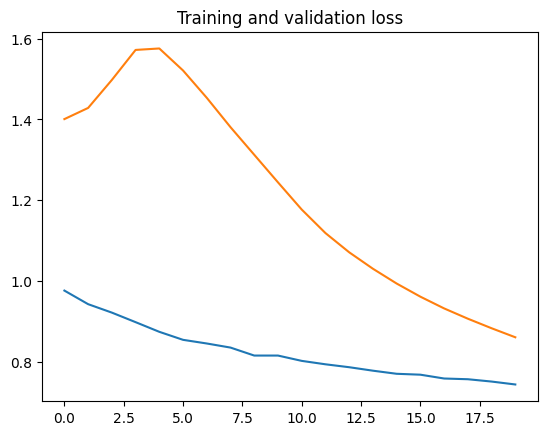

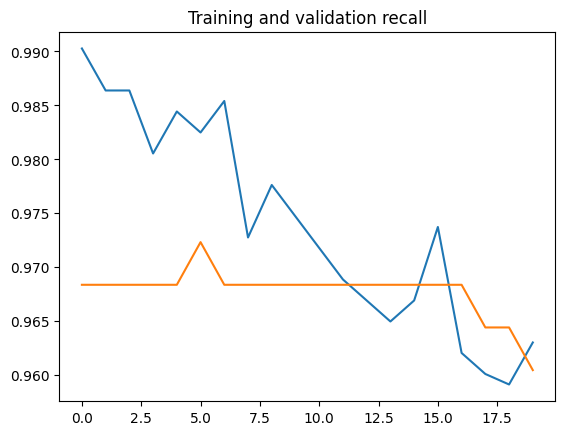

In [29]:
epochs = number_of_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation recall')
plt.plot(np.arange(0, epochs), history.history["recall"], label="train_rec")
plt.plot(np.arange(0, epochs), history.history["val_recall"], label="val_rec")

In [14]:
Y_pred = model.predict(X_test)
Y_pred_binary = np.where(Y_pred>0.5, 1, 0)
print(sklearn.metrics.classification_report(Y_test, Y_pred_binary, target_names=list_possible_materials))

5/5 [==============================] - 3s 563ms/step
                        precision    recall  f1-score   support

                raffia       0.01      1.00      0.03         2
           cow-leather       0.05      1.00      0.10         7
             palm-leaf       0.00      0.00      0.00         0
     mercerised-cotton       0.00      0.00      0.00         0
                 brass       0.00      0.00      0.00         0
                velvet       0.00      0.00      0.00         0
            Plexiglas®       0.00      0.00      0.00         2
          calf-leather       0.28      1.00      0.44        39
          polyurethane       0.03      1.00      0.06         4
               leather       0.26      1.00      0.41        36
                  jute       0.00      0.00      0.00         0
        organic-cotton       0.00      0.00      0.00         0
                canvas       0.01      1.00      0.01         1
                fabric       0.26      1.00      0

/Users/andreacivitarese/PycharmProjects/CVandDL/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andreacivitarese/PycharmProjects/CVandDL/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
supports_for_dataset = {}
print(len(labels))

for vector in labels:
    label = ''
    for index, number in enumerate(vector):
        if number == 1:
            if label == '':
                label = label + list_possible_materials[index]
            else:
                label = label + '+' + list_possible_materials[index]
    try:
        supports_for_dataset[label] = supports_for_dataset[label] + 1
    except:
        supports_for_dataset[label] = 1

print(supports_for_dataset)


1373
{'calf-leather': 401, 'lamb-leather': 113, 'fabric': 329, 'leather': 314, 'polyurethane': 14, 'organic-cotton+polyester': 2, 'calf-leather+fabric': 3, 'brass+calf-leather': 3, 'cow-leather': 87, '100%-cotton': 1, 'polyurethane+polyester': 13, 'recycled-nylon': 2, 'mercerised-cotton+polyurethane+polyester': 1, 'leather+fabric': 15, 'polyurethane+organic-cotton+polyester': 1, 'polyester': 1, 'canvas': 18, 'raffia': 20, 'polyurethane+fabric+polyester': 5, 'goat-leather': 13, 'Plexiglas®': 5, 'jute': 3, 'velvet': 1, 'lamb-leather+polyester': 1, 'plastic': 1, 'calf-leather+lamb-leather': 2, 'lamb-fur': 1, 'organic-cotton': 1, 'ethylene-vinyl-acetate': 1, 'palm-leaf': 1}


In [30]:
total = 0
for key in supports_for_dataset.keys():
    total += supports_for_dataset[key]
print(total)

1373
